In [497]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [498]:
#Generating board of the game size and number of mines
def generate_board(size, mines):
    game_board = [[0 for i in range(0, size[1])] for j in range(0,size[0])]
    mine_laying = set()
    while len(mine_laying) < mines:
        mine_laying.add((random.randint(1, size[0] - 1), random.randint(1, size[1] - 1)))
    for mine in mine_laying:
        game_board[mine[0]][mine[1]] = -1
    for i in range(size[0]):
        for j in range(size[1]):
            if game_board[i][j] == -1:
                continue
            mine_track = 0
            for x in [-1, 0, 1]:
                for y in [-1, 0, 1]:
                    if x != 0 or y != 0:
                        tem = (i + x, j + y)
                        if tem[0] >= 0 and tem[0] < size[0] and tem[1] >= 0 and tem[1] < size[1]:
                            if game_board[tem[0]][tem[1]] == -1:
                                mine_track += 1 # counting number of mines in the neighbours  and adding count to current tile
            game_board[i][j] = mine_track       #this helps us the complete set up of initial game environment
    return game_board

In [499]:
#getting possible mines in surroundings
def get_neighbors(coord,size, open_tiles):
    return_ = []
    mine_count = game_board[coord[0]][coord[1]]
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            tem = (coord[0] + i, coord[1] + j)
            if (i != 0 or j != 0) and tem[0] >= 0 and tem[0] < size[0] and  tem[1] >= 0 and tem[1] < size[1]:
                if tem in open_tiles:
                    if open_tiles[tem][0] == -1:
                        mine_count -= 1
                    continue

                return_.append(tem)
    return (mine_count, [(mine_count, set(return_))])

In [500]:
#removing neighbors potential mine right now and second are the cells to be consider clear so that we can remove
def remove_operation(open_tiles, to_separate, mine_case):
    mine_cell_track = []
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            tem = (to_separate[0] + i, to_separate[1] + j)
            if tem in open_tiles and (i != 0 or j != 0):
                mine_cell_track.append(tem)

    for neighbor in mine_cell_track:
        total_mines, possible_mines = open_tiles[neighbor]

        suspect_mines = []
        for number, mine in possible_mines:

            if to_separate in mine:
                total_mines -= mine_case
                suspect_mines.append((number - mine_case, mine - set([to_separate])))
            else:
                suspect_mines.append((number, mine))
        open_tiles[neighbor] = (total_mines, suspect_mines)
    return open_tiles

In [501]:
# Adding cells which are explored and cleared
def add_to_list(open_tiles, unknowns, size, board, unexplored):
    for something in unknowns:
        for cell in something[1]:
            if cell not in open_tiles:
                open_tiles[cell] = get_neighbors(cell, size, open_tiles)
                del unexplored[cell]
                open_tiles = remove_operation(open_tiles, cell, 0)
                board[cell[0]][cell[1]] = game_board[cell[0]][cell[1]]
    return open_tiles


def count_unknown_neighbors(unknowns):

    to_return1 = 0
    for mine_laying in unknowns[1]:
        to_return1 += len(mine_laying)
    return to_return1

In [502]:
#calculting probabilities so that we can actually make a reasonable guess and also get a better approach
def get_probabilities(open_tiles, cells):
    min_probability = float('inf')
    min_set = set()
    for prob_cell in cells:
        for num, mine_laying in open_tiles[prob_cell][1]:
            if len(mine_laying) == 0:
                continue
            if num == 0:
                return (0, mine_laying)
            current_probability = float(num)/len(mine_laying)
            if current_probability < min_probability:
                min_probability = current_probability
                min_set = mine_laying
    return (min_probability, min_set)


In [503]:
# driver function for getting infomration from the interaction of multiple cells and getting configurations
def extract_info_surrounding(known_cell, cell):
    intersecting_cells = []
    for i in [-2, -1, 0, 1, 2]:
        for j in [-2, -1, 0, 1, 2]:
            if i == 0 and j == 0:
                continue
            tem = (cell[0] + i, cell[1] + j)
            if tem in known_cell and known_cell[tem][0] not in [-2, 0, -1]:
                intersecting_cells.append(tem)
    flag_upgrade = False
    for inter_cell in intersecting_cells:
        cell_crossing = known_cell[cell]
        tem_track = {}
        for number, mine_laying in cell_crossing[1]:
            sharing_tiles = known_cell[inter_cell]
            flag = False
            for inum, xmines in sharing_tiles[1]:
                left = (mine_laying, cell, number) if number < inum else (xmines, inter_cell, inum)
                right =  (mine_laying, cell, number) if number >= inum else (xmines, inter_cell, inum)
                inter = left[0] & right[0] 
                uni_left = set() 
                uni_right = set()
                if inter != set():
                    uni_left = left[0] - right[0] 
                    uni_right = right[0] - left[0]
                else:
                    tem_track.setdefault(inter_cell, []).append((inum, xmines))
                    continue
                if uni_left == set():
                    flag_upgrade = True if uni_right != set() else False
                    flag = True
                    new_right = [(left[2], left[0]), (right[2] - left[2], uni_right)]
              
                    if uni_right == set():
                        new_right.pop()
                    tem_track.setdefault(right[1], []) 
                    tem_track[right[1]] = tem_track[right[1]] + new_right
                    tem_track.setdefault(left[1], []).append((left[2], left[0]))
                    break
                else:
                    count_valid = 0
                    valid_arrange = ()
                    for i in range(0, min(len(uni_left), left[2]) + 1):
                        inter_count = left[2] - i
                        if inter_count > len(inter):
                            continue
                        if right[2] - inter_count > len(uni_right):
                            continue
                        count_valid += 1
                        if count_valid > 1:
                            break
                        valid_arrange = (i, inter_count, right[2] - inter_count)   
                    if count_valid == 1:
                        flag_upgrade = True

                        tem_track.setdefault(left[1], []) 
                        tem_track[left[1]] = tem_track[left[1]] + [(valid_arrange[0], uni_left),
                                (valid_arrange[1], inter)]
                        tem_track.setdefault(right[1], []) 
                        tem_track[right[1]] = tem_track[right[1]] + [(valid_arrange[1], inter),
                                (valid_arrange[2], uni_right)]
                        flag = True
                        break
                    else:
                        tem_track.setdefault(inter_cell, []).append((inum, xmines))
            if not flag:
                tem_track.setdefault(cell, []).append((number, mine_laying))
                
            known_cell[inter_cell] = (known_cell[inter_cell][0], tem_track[inter_cell])
            tem_track[inter_cell] = []
        known_cell[cell] = (known_cell[cell][0], tem_track[cell])
        tem_track[cell] = []
    return known_cell, get_probabilities(known_cell, [cell] + intersecting_cells), flag_upgrade

In [504]:
#driver funcation to play the board
def play(size):
    hit_mine=0
    board = [[-2 for i in range(size[1])] for j in range(size[0])]
    unseen = {}
    for row in range(size[0]):
        for col in range(size[1]):
            unseen[(row, col)] = 0
    done = False

    open_tiles = {} #the cells which have been opened and have unknown neighbors 
    if game_board[0][0] == -1: #if the fisrt tile is mine
        hit_min+=1
    del unseen[(0, 0)]
    open_tiles[(0,0)] = get_neighbors((0, 0), size, open_tiles)
    while not done:
        update_flag = False
        minimum_prob = (float('inf'), set())
        for cell in list(open_tiles.keys()):
            unknowns = open_tiles[cell]
            if unknowns[0] in [-2, -1]:
                continue
            clear_coord = []
            for i in range(len(unknowns[1])):
                if unknowns[1][i][0] == 0:
                    open_tiles = add_to_list(open_tiles, [unknowns[1][i]], size, board, unseen)
                    clear_coord.append(i)
                    update_flag = True
                    
                elif unknowns[1][i][0] == len(unknowns[1][i][1]):
                    clear_coord.append(i)
                    update_flag = True
                    for mine_cell in unknowns[1][i][1]:
                        remove_operation(open_tiles, mine_cell, 1)
                        open_tiles[mine_cell] = (-1, [])
                        del unseen[mine_cell]
                        board[mine_cell[0]][mine_cell[1]] = -1

            if clear_coord == []:

                open_tiles, cur_minimum_prob, cur_flag = extract_info_surrounding(open_tiles, cell)
                if cur_flag == True:
                    update_flag = True
                if cur_minimum_prob[0] < minimum_prob[0]:
                    minimum_prob = cur_minimum_prob

                division_flag = True
            
            count = 0
            for ind in clear_coord:

                del unknowns[1][ind - count]
                count += 1
            if unknowns[1] == []:
                open_tiles[cell] = (-2, [])

        if update_flag == False:
            
            random_cell = (0, 0)
            #print("Guesssing")
            if minimum_prob[0] == float('inf') and len(unseen) > 0:
                random_cell = list(unseen.keys())[random.randint(0, len(unseen) - 1)] #taking a random guess at this point

            elif minimum_prob[0] == float('inf'):
                done = 1
                continue
            else:
                random_cell = random.sample(minimum_prob[1], 1)[0]            
            if game_board[random_cell[0]][random_cell[1]] == -1:
                hit_mine+=1
                continue
            else:
                open_tiles = add_to_list(open_tiles, [(0, set([random_cell]))], size, board, unseen)
        #for i in range(len(board)):  #uncomment to keep track of play by play changes on the board
         #   print(board[i])
        #input('Any key to continue') # uncomment to get play by play progress

    return True,hit_mine

In [685]:
time_trac=[]
mines_hit_after_every_itrn=[]

In [697]:
#playing game and collecting results
#itrn=10
#for i in range(itrn):
start = time.time()
size = (20,20)
mine_density=0.2
mines = int(mine_density*size[0]*size[0])
game_board = generate_board(size, mines)
result = play(size)
print(result)

(True, 4)
(True, 3)
(True, 2)
(True, 0)
(True, 13)
(True, 20)
(True, 4)
(True, 3)
(True, 6)
(True, 0)


In [645]:
mines_hit_after_every_itrn.append(result[1])
elapsed_time_fl = (time.time() - start)
time_trac.append(elapsed_time_fl)

In [646]:
#running the cell 10 times with varying mine density and appending the results
#mines_hit_after_every_itrn.remove(70)
avg_mines_hit=sum(mines_hit_after_every_itrn)/10
avg_final_score= avg_mines_hit/(mine_density*size[0]*size[0])
avg_time=sum(time_trac)/10
print(time_trac,avg_time,mine_density)
print(mines_hit_after_every_itrn,avg_mines_hit,avg_final_score)

[2.9672391414642334, 5.224443435668945, 6.653937101364136, 2.1775810718536377, 2.077787160873413, 2.859860420227051, 2.723099946975708, 2.274573564529419, 1.6224215030670166, 9.781442642211914, 4.82940936088562, 3.164858341217041, 2.24066162109375, 2.039823532104492, 1.9311532974243164, 1.8907830715179443, 1.692711591720581, 2.040891170501709, 2.5364372730255127, 2.4114186763763428] 6.314053392410278 0.45
[142, 99, 130, 84, 100, 101, 120, 126, 89, 95] 108.6 0.6033333333333333


In [353]:
#variables for ploting graph
y=[] #storing avg final score
z=[] #storing avg time

In [ ]:
#appdending data for plotting
y.append(avg_final_score)
z.append(avg_time)

In [662]:
#print(x,y,z)
x=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.45,0.5]

[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.45] [0.005, 0.0075, 0.03333333333333333, 0.08125, 0.258, 0.3458333333333333, 0.44190476190476186, 0.5225, 0.6033333333333333] [0.010481977462768554, 0.013164901733398437, 0.050132465362548825, 0.0878286361694336, 0.18188192844390869, 0.17842283248901367, 0.06099259853363037, 3.8362385988235475, 6.314053392410278]


(0.0, 0.7)

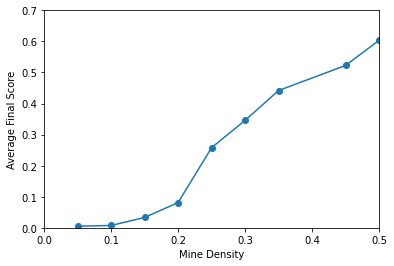

In [680]:
#plotting results
plt.plot(x, y, marker = 'o')
plt.xlabel("Mine Density")
plt.ylabel("Average Final Score")
plt.xlim(0, 0.5)
plt.ylim(0, 0.7)

In [299]:
#Note : chagning size manually here
start = time.time()
size = (20,20)
mine_density=0.1
mines = mine_density*size[0]*size[0]
game_board = generate_board(size, mines)
count = play(size)
print(count)
elapsed_time_fl = (time.time() - start)
time_track.append(elapsed_time_fl)

(True, 92)


In [298]:
#print(time_track)
x=[5,10,15,20,25,30,35,40,45,50,60,100]

[0.06984591484069824, 0.07982110977172852]


Text(0, 0.5, 'Time taken in mins')

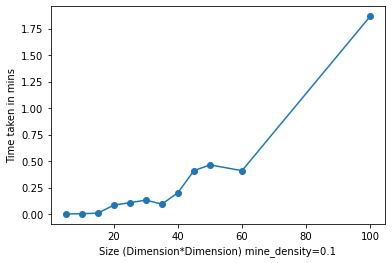

In [282]:
# plotting size at constant density vs size
plt.plot(x, time_track,marker = 'o')
plt.xlabel("Size (Dimension*Dimension) mine_density=0.1")
plt.ylabel("Time taken in mins")